In [22]:
%pylab inline
%load_ext autoreload
%autoreload 2

from __future__ import division
from __future__ import print_function

import os
import copy
import argparse
import fnmatch
import numpy as np

import scipy
from scipy.interpolate import interp1d

# Astropy
from astropy.io import fits
from astropy    import units as u
from astropy.stats import sigma_clip
# AstroML
from astroML.plotting import hist
# Astropy.Table
from astropy.table import Table, Column, MaskedColumn, TableColumns

# Matplotlib related
# Matplotlib default settings
rcdef = plt.rcParams.copy()
pylab.rcParams['figure.figsize'] = 12, 10
pylab.rcParams['xtick.major.size'] = 8.0
pylab.rcParams['xtick.major.width'] = 2.5
pylab.rcParams['xtick.minor.size'] = 4.0
pylab.rcParams['xtick.minor.width'] = 2.5
pylab.rcParams['ytick.major.size'] = 8.0
pylab.rcParams['ytick.major.width'] = 2.5
pylab.rcParams['ytick.minor.size'] = 4.0
pylab.rcParams['ytick.minor.width'] = 2.5
pylab.rcParams['legend.numpoints'] = 1

import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
from matplotlib.ticker import NullFormatter
from matplotlib.ticker import MaxNLocator

# Shapely related imports
from shapely.geometry import Polygon, LineString, Point
from shapely          import wkb
from shapely.ops      import cascaded_union

Populating the interactive namespace from numpy and matplotlib
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


`%matplotlib` prevents importing * from pylab and numpy


In [5]:
# SDSS pivot wavelength 
sdss_u_pivot = 3551.0
sdss_g_pivot = 4686.0
sdss_r_pivot = 6165.0
sdss_i_pivot = 7481.0
sdss_z_pivot = 8931.0

# GALEX pivot wavelength 
galex_fuv_pivot = 1535.0
galex_nuv_pivot = 2301.0

# WISE pivot wavelength 
wise_w1_pivot = 34000.0
wise_w2_pivot = 46000.0

# HSC pivot wavelength 
hsc_g_pivot = 4782.2
hsc_r_pivot = 6101.7 
hsc_i_pivot = 7648.0 
hsc_z_pivot = 8883.0
hsc_y_pivot = 9750.8

hsc_filters = np.asarray([hsc_g_pivot, hsc_r_pivot, hsc_i_pivot, hsc_z_pivot, hsc_y_pivot])

# Read in the matched GAMA-HSC data and show the column names

In [63]:
def hscFlux2AB(flux, zero=27.0): 
    """
    Convert HSC flux in unit of ADU to AB magnitude 
    
    So far, constant zeropoint is applied to the calibration 
    """
    
    try: 
        mag = -2.5 * np.log10(flux) + zero
    except NameError: 
        import numpy as np 
        mag = -2.5 * np.log10(flux) + zero
    
    return mag


def hscMag2Flux(mag, unit='maggy'):
    """
    Convert HSC AB magnitude into physical flux 
    
    Three units can be used here: 
    
    unit='maggy/nanomaggy/jy'
    """
    
    flux = 10.0 ** (-0.4 * mag) 
    
    if unit.lower().strip() == 'jy': 
        return (flux * 3631.0)
    elif unit.lower().strip() == 'maggy': 
        return flux 
    elif unit.lower().strip() == 'nanomaggy':
        return (flux * 1.0E-9)
    else: 
        raise Exception("## Wrong unit, should be jy/maggy/nanomaggy")
        
        
def hscMaggy2AB(flux):
    """
    Convert flux in unit of Maggies into AB magnitude
    """
    
    return (np.log10(flux) / -0.4)
        
    
def hscMaggyErr2ABErr(flux, fluxErr, ivar=False):
    """
    Convert (flux, fluxErr) into AB magnitude error 
    """
    
    if ivar: 
        fluxErr = np.sqrt(1.0 / fluxErr)
    
    return (2.5 * np.log10((flux + fluxErr) / flux))
    
    
def hscMagerr2Ivar(flux, magErr): 
    """
    Get the inverse variance of flux estimates from Flux and magErr 
    """
    
    fluxErr = flux * ((10.0 ** (magErr/2.5)) - 1.0)
    
    return (1.0 / (fluxErr ** 2.0))


def hscMagerr2Fluxerr(flux, magErr): 
    """
    Get the inverse variance of flux estimates from Flux and magErr 
    """
    
    fluxErr = flux * ((10.0 ** (magErr/2.5)) - 1.0)
    
    return fluxErr

def hscFluxSNR2Ivar(flux, snr): 
    """
    Estimate inverse variance of flux error using HSC flux and snr 
    """
    
    fluxErr = flux * snr 
    
    return (1.0 / (fluxErr ** 2.0))

In [48]:
gama_match = '/Users/songhuang/Desktop/gama_compare/hsc_gama_dr15a_matched.fits'
data = fits.open(gama_match)[1].data

In [49]:
data.columns

ColDefs(
    name = 'ra_hsc'; format = 'D'
    name = 'dec_hsc'; format = 'D'
    name = 'tract'; format = 'I'; null = -32768
    name = 'patch'; format = '3A'
    name = 'id'; format = 'K'; null = -9223372036854775808
    name = 'parent'; format = 'K'; null = -9223372036854775808
    name = 'a_g'; format = 'D'
    name = 'a_r'; format = 'D'
    name = 'a_i'; format = 'D'
    name = 'a_z'; format = 'D'
    name = 'a_y'; format = 'D'
    name = 'imag_aperture01'; format = 'D'
    name = 'imag_aperture02'; format = 'D'
    name = 'imag_aperture03'; format = 'D'
    name = 'imag_aperture04'; format = 'D'
    name = 'imag_aperture05'; format = 'D'
    name = 'imag_aperture06'; format = 'D'
    name = 'imag_aperture07'; format = 'D'
    name = 'imag_aperture08'; format = 'D'
    name = 'imag_aperture09'; format = 'D'
    name = 'gmag_psf'; format = 'D'
    name = 'gmag_psf_err'; format = 'D'
    name = 'rmag_psf'; format = 'D'
    name = 'rmag_psf_err'; format = 'D'
    name = 'imag_psf'; f

# Estimate the correct SNR using Kron magnitude 

In [50]:
fKron_g = hscMag2Flux(data['gmag_kron'] - data['a_g'], unit='maggy')
snrKron_g = fKron_g / hscMagerr2Fluxerr(fKron_g, data['gmag_kron_err'])

fKron_r = hscMag2Flux(data['rmag_kron'] - data['a_r'], unit='maggy')
snrKron_r = fKron_r / hscMagerr2Fluxerr(fKron_r, data['rmag_kron_err'])

fKron_i = hscMag2Flux(data['imag_kron'] - data['a_i'], unit='maggy')
snrKron_i = fKron_i / hscMagerr2Fluxerr(fKron_i, data['imag_kron_err'])

fKron_z = hscMag2Flux(data['zmag_kron'] - data['a_z'], unit='maggy')
snrKron_z = fKron_z / hscMagerr2Fluxerr(fKron_z, data['zmag_kron_err'])

fKron_y = hscMag2Flux(data['ymag_kron'] - data['a_y'], unit='maggy')
snrKron_y = fKron_y / hscMagerr2Fluxerr(fKron_y, data['ymag_kron_err'])

In [51]:
fCmodel_i = hscMag2Flux(data['imag_cmodel'] - data['a_i'], unit='maggy')
snrCmodel_i = fCmodel_i / hscMagerr2Fluxerr(fCmodel_i, data['imag_cmodel_err'])

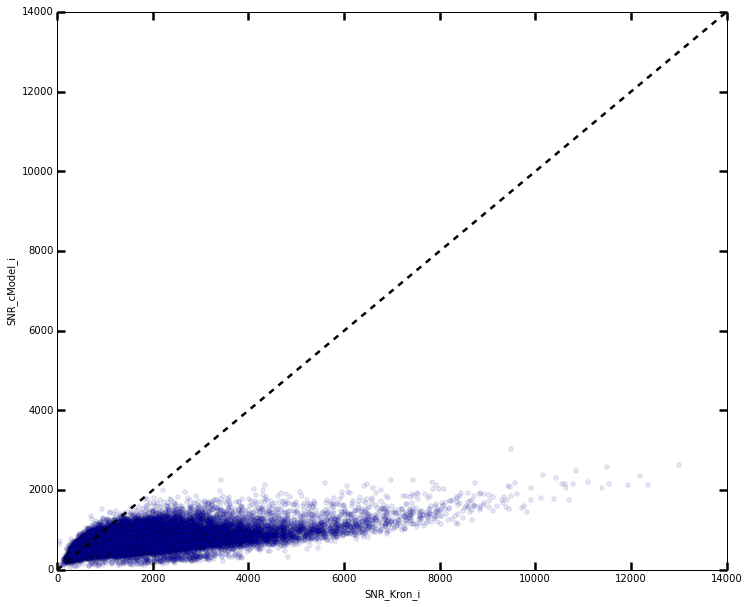

In [52]:
plt.plot(np.linspace(0, 14000, 100), np.linspace(0, 14000, 100), 
         linestyle='dashed', color='k', linewidth=2.5)
plt.scatter(snrKron_i, snrCmodel_i,
            alpha=0.1)
plt.xlim(-0.1, 14000)
plt.ylim(-0.1, 14000)
plt.xlabel('SNR_Kron_i')
plt.ylabel('SNR_cModel_i')

# Convert the HSC magnitude and magnitude error to flux and flux error 

## HSC cModel

In [53]:
cMaggy_g = hscMag2Flux(data['gmag_cmodel'] - data['a_g'], unit='maggy')
cIvar_g = hscMagerr2Ivar(cMaggy_g, data['gmag_cmodel_err'])
cIvar_g_new = hscFluxSNR2Ivar(cMaggy_g, snrKron_g)

cMaggy_r = hscMag2Flux(data['rmag_cmodel'] - data['a_r'], unit='maggy')
cIvar_r = hscMagerr2Ivar(cMaggy_r, data['rmag_cmodel_err'])
cIvar_r_new = hscFluxSNR2Ivar(cMaggy_r, snrKron_r)

cMaggy_i = hscMag2Flux(data['imag_cmodel'] - data['a_i'], unit='maggy')
cIvar_i = hscMagerr2Ivar(cMaggy_i, data['imag_cmodel_err'])
cIvar_i_new = hscFluxSNR2Ivar(cMaggy_i, snrKron_i)

cMaggy_z = hscMag2Flux(data['zmag_cmodel'] - data['a_z'], unit='maggy')
cIvar_z = hscMagerr2Ivar(cMaggy_z, data['zmag_cmodel_err'])
cIvar_z_new = hscFluxSNR2Ivar(cMaggy_z, snrKron_z)

cMaggy_y = hscMag2Flux(data['ymag_cmodel'] - data['a_y'], unit='maggy')
cIvar_y = hscMagerr2Ivar(cMaggy_y, data['ymag_cmodel_err'])
cIvar_y_new = hscFluxSNR2Ivar(cMaggy_y, snrKron_y)

In [54]:
# Stack
cMaggies    = np.dstack((cMaggy_g, cMaggy_r, cMaggy_i, cMaggy_z, cMaggy_y))[0]
cMagIvar    = np.dstack((cIvar_g, cIvar_r, cIvar_i, cIvar_z, cIvar_y))[0]
cMagIvarNew = np.dstack((cIvar_g_new, cIvar_r_new, cIvar_i_new, cIvar_z_new, cIvar_y_new))[0]

## HSC Exp

In [55]:
eMaggy_g = hscMag2Flux(data['gmag_cmodel_exp'] - data['a_g'], unit='maggy')
eIvar_g = hscMagerr2Ivar(eMaggy_g, data['gmag_cmodel_exp_err'])
eIvar_g_new = hscFluxSNR2Ivar(eMaggy_g, snrKron_g)

eMaggy_r = hscMag2Flux(data['rmag_cmodel_exp'] - data['a_r'], unit='maggy')
eIvar_r = hscMagerr2Ivar(eMaggy_r, data['rmag_cmodel_exp_err'])
eIvar_r_new = hscFluxSNR2Ivar(eMaggy_r, snrKron_r)

eMaggy_i = hscMag2Flux(data['imag_cmodel_exp'] - data['a_i'], unit='maggy')
eIvar_i = hscMagerr2Ivar(eMaggy_i, data['imag_cmodel_exp_err'])
eIvar_i_new = hscFluxSNR2Ivar(eMaggy_i, snrKron_i)

eMaggy_z = hscMag2Flux(data['zmag_cmodel_exp'] - data['a_z'], unit='maggy')
eIvar_z = hscMagerr2Ivar(eMaggy_z, data['zmag_cmodel_exp_err'])
eIvar_z_new = hscFluxSNR2Ivar(eMaggy_z, snrKron_z)

eMaggy_y = hscMag2Flux(data['ymag_cmodel_exp'] - data['a_y'], unit='maggy')
eIvar_y = hscMagerr2Ivar(eMaggy_y, data['ymag_cmodel_exp_err'])
eIvar_y_new = hscFluxSNR2Ivar(eMaggy_y, snrKron_y)

In [56]:
# Stack
eMaggies    = np.dstack((eMaggy_g, eMaggy_r, eMaggy_i, eMaggy_z, eMaggy_y))[0]
eMagIvar    = np.dstack((eIvar_g, eIvar_r, eIvar_i, eIvar_z, eIvar_y))[0]
eMagIvarNew = np.dstack((eIvar_g_new, eIvar_r_new, eIvar_i_new, eIvar_z_new, eIvar_y_new))[0]

## HSC DeV

In [57]:
dMaggy_g = hscMag2Flux(data['gmag_cmodel_dev'] - data['a_g'], unit='maggy')
dIvar_g = hscMagerr2Ivar(dMaggy_g, data['gmag_cmodel_dev_err'])
dIvar_g_new = hscFluxSNR2Ivar(dMaggy_g, snrKron_g)

dMaggy_r = hscMag2Flux(data['rmag_cmodel_dev'] - data['a_r'], unit='maggy')
dIvar_r = hscMagerr2Ivar(dMaggy_r, data['rmag_cmodel_dev_err'])
dIvar_r_new = hscFluxSNR2Ivar(dMaggy_r, snrKron_r)

dMaggy_i = hscMag2Flux(data['imag_cmodel_dev'] - data['a_i'], unit='maggy')
dIvar_i = hscMagerr2Ivar(dMaggy_i, data['imag_cmodel_dev_err'])
dIvar_i_new = hscFluxSNR2Ivar(dMaggy_i, snrKron_i)

dMaggy_z = hscMag2Flux(data['zmag_cmodel_dev'] - data['a_z'], unit='maggy')
dIvar_z = hscMagerr2Ivar(dMaggy_z, data['zmag_cmodel_dev_err'])
dIvar_z_new = hscFluxSNR2Ivar(dMaggy_z, snrKron_z)

dMaggy_y = hscMag2Flux(data['ymag_cmodel_dev'] - data['a_y'], unit='maggy')
dIvar_y = hscMagerr2Ivar(dMaggy_y, data['ymag_cmodel_dev_err'])
dIvar_y_new = hscFluxSNR2Ivar(dMaggy_y, snrKron_y)

In [58]:
# Stack
dMaggies    = np.dstack((dMaggy_g, dMaggy_r, dMaggy_i, dMaggy_z, dMaggy_y))[0]
dMagIvar    = np.dstack((dIvar_g, dIvar_r, dIvar_i, dIvar_z, dIvar_y))[0]
dMagIvarNew = np.dstack((dIvar_g_new, dIvar_r_new, dIvar_i_new, dIvar_z_new, dIvar_y_new))[0]

# Save Table

In [59]:
## Read a short version of the matched catalog 

gama_short = '/Users/songhuang/Desktop/gama_compare/hsc_gama_dr15a_matched_short.fits'
table = Table.read(gama_short, format='fits')

## Add few columns 
## cModel

c1 = Column(name='cMaggies', data=cMaggies)
table.add_column(c1)

c2 = Column(name='cMagIvar', data=cMagIvar)
table.add_column(c2)

c2new = Column(name='cMagIvarNew', data=cMagIvarNew)
table.add_column(c2new)

## Exp 

c3 = Column(name='eMaggies', data=eMaggies)
table.add_column(c3)

c4 = Column(name='eMagIvar', data=eMagIvar)
table.add_column(c4)

c4new = Column(name='eMagIvarNew', data=eMagIvarNew)
table.add_column(c4new)

## DeV

c5 = Column(name='dMaggies', data=dMaggies)
table.add_column(c5)

c6 = Column(name='dMagIvar', data=dMagIvar)
table.add_column(c6)

c6new = Column(name='dMagIvarNew', data=dMagIvarNew)
table.add_column(c6new)

# Keep the useful ones: 

tabUse = table[(table['z_use'] > 0.0001) & 
               (table['z_use'] < 0.7000) &
               (np.isfinite(table['gmag_cmodel'])) & 
               (np.isfinite(table['gmag_cmodel_err'])) & 
               (np.isfinite(table['rmag_cmodel'])) & 
               (np.isfinite(table['rmag_cmodel_err'])) &
               (np.isfinite(table['imag_cmodel'])) & 
               (np.isfinite(table['imag_cmodel_err'])) &
               (np.isfinite(table['zmag_cmodel'])) & 
               (np.isfinite(table['zmag_cmodel_err'])) & 
               (np.isfinite(table['ymag_cmodel'])) & 
               (np.isfinite(table['ymag_cmodel_err'])) & 
               (table['gmag_cmodel'] >= 14.0) & 
               (table['gmag_cmodel'] <= 25.0) & 
               (table['rmag_cmodel'] >= 14.0) & 
               (table['rmag_cmodel'] <= 24.0) &
               (table['imag_cmodel'] >= 13.5) & 
               (table['imag_cmodel'] <= 23.0) & 
               (table['zmag_cmodel'] >= 13.5) & 
               (table['zmag_cmodel'] <= 24.0) & 
               (table['ymag_cmodel'] >= 13.0) & 
               (table['ymag_cmodel'] <= 24.0)] 
print("%i / %i are useful" % (len(tabUse), len(table)))

# Sort based on redshift 
tabUse.sort('z_use')

# Save the table
gama_short = '/Users/songhuang/Desktop/gama_compare/hsc_gama_dr15a_matched_flux_use.fits'
tabUse.write(gama_short, format='fits', overwrite='True')

39541 / 40874 are useful


/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:62: RuntimeWarning: invalid value encountered in greater_equal
/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:62: RuntimeWarning: invalid value encountered in less_equal
/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:63: RuntimeWarning: invalid value encountered in less_equal


# Save a table that only includes four bands 

In [60]:
# Stack
cMaggies4    = np.dstack((cMaggy_g, cMaggy_r, cMaggy_i, cMaggy_z))[0]
cMagIvar4    = np.dstack((cIvar_g, cIvar_r, cIvar_i, cIvar_z))[0]
cMagIvarNew4 = np.dstack((cIvar_g_new, cIvar_r_new, cIvar_i_new, cIvar_z_new))[0]

eMaggies4    = np.dstack((eMaggy_g, eMaggy_r, eMaggy_i, eMaggy_z))[0]
eMagIvar4    = np.dstack((eIvar_g, eIvar_r, eIvar_i, eIvar_z))[0]
eMagIvarNew4 = np.dstack((eIvar_g_new, eIvar_r_new, eIvar_i_new, eIvar_z_new))[0]

dMaggies4    = np.dstack((dMaggy_g, dMaggy_r, dMaggy_i, dMaggy_z))[0]
dMagIvar4    = np.dstack((dIvar_g, dIvar_r, dIvar_i, dIvar_z))[0]
dMagIvarNew4 = np.dstack((dIvar_g_new, dIvar_r_new, dIvar_i_new, dIvar_z_new))[0]


## Read a short version of the matched catalog 

gama_short = '/Users/songhuang/Desktop/gama_compare/hsc_gama_dr15a_matched_short.fits'
table4 = Table.read(gama_short, format='fits')

## Add few columns 
## cModel

c1 = Column(name='cMaggies', data=cMaggies4)
table4.add_column(c1)

c2 = Column(name='cMagIvar', data=cMagIvar4)
table4.add_column(c2)

c2new = Column(name='cMagIvarNew', data=cMagIvarNew4)
table4.add_column(c2new)

## Exp 

c3 = Column(name='eMaggies', data=eMaggies4)
table4.add_column(c3)

c4 = Column(name='eMagIvar', data=eMagIvar4)
table4.add_column(c4)

c4new = Column(name='eMagIvarNew', data=eMagIvarNew4)
table4.add_column(c4new)

## DeV

c5 = Column(name='dMaggies', data=dMaggies4)
table4.add_column(c5)

c6 = Column(name='dMagIvar', data=dMagIvar4)
table4.add_column(c6)

c6new = Column(name='dMagIvarNew', data=dMagIvarNew4)
table4.add_column(c6new)

# Keep the useful ones: 

tabUse4 = table4[(table4['z_use'] > 0.0001) & 
                 (table4['z_use'] < 0.7000) &
                 (np.isfinite(table4['gmag_cmodel'])) & 
                 (np.isfinite(table4['gmag_cmodel_err'])) & 
                 (np.isfinite(table4['rmag_cmodel'])) & 
                 (np.isfinite(table4['rmag_cmodel_err'])) &
                 (np.isfinite(table4['imag_cmodel'])) & 
                 (np.isfinite(table4['imag_cmodel_err'])) &
                 (np.isfinite(table4['zmag_cmodel'])) & 
                 (np.isfinite(table4['zmag_cmodel_err'])) & 
                 (table4['gmag_cmodel'] >= 14.0) & 
                 (table4['gmag_cmodel'] <= 25.0) & 
                 (table4['rmag_cmodel'] >= 14.0) & 
                 (table4['rmag_cmodel'] <= 24.0) &
                 (table4['imag_cmodel'] >= 13.5) & 
                 (table4['imag_cmodel'] <= 23.0) & 
                 (table4['zmag_cmodel'] >= 13.5) & 
                 (table4['zmag_cmodel'] <= 24.0)]

print("%i / %i are useful" % (len(tabUse4), len(table4)))

# Sort based on redshift 
tabUse4.sort('z_use')

# Save the table
gama_short4 = '/Users/songhuang/Desktop/gama_compare/hsc_gama_dr15a_matched_flux_use4.fits'
tabUse4.write(gama_short4, format='fits', overwrite='True')

39560 / 40874 are useful


/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:72: RuntimeWarning: invalid value encountered in greater_equal
/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:72: RuntimeWarning: invalid value encountered in less_equal
/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:73: RuntimeWarning: invalid value encountered in less_equal


# Show HSC SEDs 

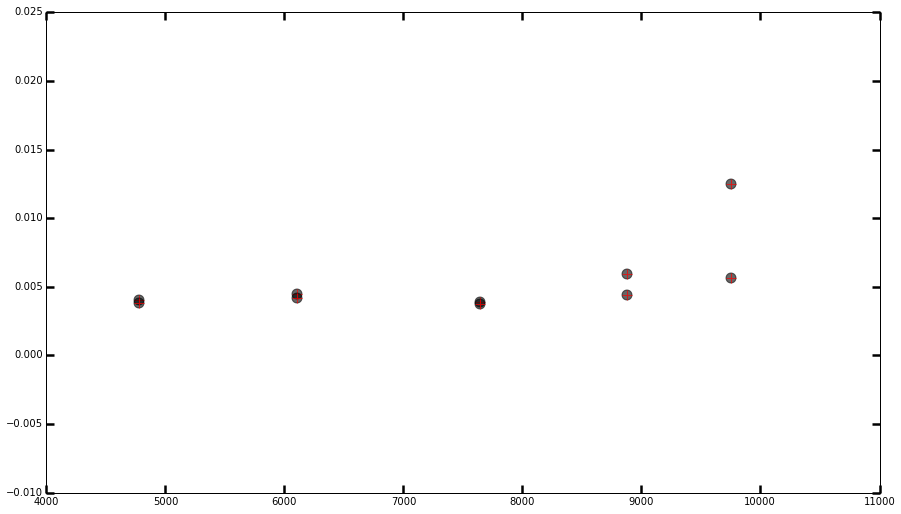

In [64]:
fig = plt.figure(figsize=(13, 7.5))
#fig.subplots_adjust(left=0.1, right=0.95, bottom=0.15)
rec = [0.10, 0.10, 0.89, 0.89]
ax1 = plt.axes(rec)

for i in range(2):
    
    galaxy = tabUse[i]
    
    waveRest = hsc_filters / (1.0 + galaxy['z_use'])
    
    cmag = np.asarray([galaxy['gmag_cmodel_err'], 
                       galaxy['rmag_cmodel_err'], 
                       galaxy['imag_cmodel_err'], 
                       galaxy['zmag_cmodel_err'], 
                       galaxy['ymag_cmodel_err']])
    
    emag = np.asarray([galaxy['gmag_cmodel_exp'], 
                       galaxy['rmag_cmodel_exp'], 
                       galaxy['imag_cmodel_exp'], 
                       galaxy['zmag_cmodel_exp'], 
                       galaxy['ymag_cmodel_exp']])
    
    dmag = np.asarray([galaxy['gmag_cmodel_dev'], 
                       galaxy['rmag_cmodel_dev'], 
                       galaxy['imag_cmodel_dev'], 
                       galaxy['zmag_cmodel_dev'], 
                       galaxy['ymag_cmodel_dev']])
    
    ax1.scatter(waveRest, cmag, marker='o', s=100, c='k', alpha=0.6)
    #ax1.scatter(waveRest, emag, marker='o', s=90, c='b', alpha=0.7)
    #ax1.scatter(waveRest, dmag, marker='o', s=90, c='r', alpha=0.7)

    
    ax1.scatter(waveRest, hscMaggyErr2ABErr(galaxy['cMaggies'], galaxy['cMagIvar'], ivar=True), 
                marker='+', s=100, c='r', alpha=0.7)

    
#ylim = ax1.get_ylim()
#ax1.set_ylim(ylim[1], ylim[0])